In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
from collections import Counter
from nltk.stem import porter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from bs4 import BeautifulSoup

In [3]:
import scipy as sp
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer, CountVectorizer

In [4]:
import gensim
from gensim.models.doc2vec import Doc2Vec
from gensim.test.utils import get_tmpfile

In [5]:
data = pd.read_json('data/train.json')

In [6]:
data = data.reset_index()
data.rename(columns={'index':'doc_id'}, inplace=True) 

# Features

### CountVectorizer 

In [7]:
def get_all_features(data):
    all_features = []
    for feature_array in data['features'].values:
        if len(feature_array) > 0:
            for features in feature_array:
                all_features.append(features)
    return all_features

In [8]:
all_features = get_all_features(data)

In [9]:
data['num_of_features'] =data['features'].apply(len)

In [10]:
cv = CountVectorizer(stop_words='english', min_df=18, max_df = 0.9)
cv_fit = cv.fit_transform(all_features)
feature_name = cv.get_feature_names()

### TfidfVectorizer

In [11]:
import re
def word_to_phrase(flist):
    plist = []
    if len(flist) > 0:
        for feature in flist:
            feature = re.sub('[_]',' ',feature)
            feature = feature.strip()
            feature_p = ''.join(feature.split(' '))
            plist.append(feature_p)
    return plist

In [12]:
def list_to_string(flist):
    string = ' '.join(flist)
    return string

In [13]:
data['features_phr'] = data['features'].apply(word_to_phrase)
data['features_phr_str'] = data['features_phr'].apply(list_to_string)

In [14]:
phr_tfidf = TfidfVectorizer(min_df=2, max_features=200, strip_accents='unicode', lowercase=True, token_pattern=r'\w{3,}', stop_words='english')  
phr_tfidf_fit =phr_tfidf.fit_transform(data['features_phr_str'])
phr_names = [x for x in phr_tfidf.get_feature_names()]
data['features_phr_vec'] = pd.Series(phr_tfidf_fit.toarray().tolist())

In [15]:
data['features_str'] = data['features'].apply(list_to_string)

In [16]:
wd_tfidf = TfidfVectorizer(min_df=2, max_features=300, strip_accents='unicode', lowercase=True, token_pattern=r'\w{3,}', stop_words='english')  
wd_tfidf_fit = wd_tfidf.fit_transform(data['features_str'])
wd_names = [x for x in wd_tfidf.get_feature_names()]
data['features_vec'] = pd.Series(wd_tfidf_fit.toarray().tolist())

In [17]:
def extract_features(df):
    classifier = {
        "dogs": ("dogs", "dog"),
        "cats": ("cats", "cat"),
        "allowed":("allowed","allow"),
        "nofee": ("no fee", "no-fee", "no  fee", "nofee", "no_fee"),
        "lowfee": ("reduced_fee", "low_fee", "reduced fee", "low fee"),
        "security": ("concierge", "doorman", "housekeep", "in_super"),
        "laundry": ("laundry", "lndry"),
        "health": ("health", "gym", "fitness", "training","wheelchair"),
        "transport": ("train", "subway", "transport"),
        "parking": ("parking"),
        "hardwood": ("hardwood"),
        "utilities": ("utilities", "heat water", "water included","garden",'Dishwasher',)
    }

    def search_feature(feature):
        return lambda s: int(any([x in s for x in feature]))

    features = df["features"].apply(list_to_string)   # convert features to string
    features = features.str.lower()
    for key in classifier:
        df['feature_'+key] = features.apply(search_feature(classifier[key]))

    return df

In [18]:
data = extract_features(data)

### Wordcloud

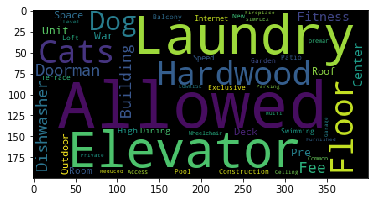

In [19]:
def word_cloud(all_features):
    string = ' '.join(all_features).strip()
    wordcloud = WordCloud(max_words=50,collocations = False).generate(string)
    return plt.imshow(wordcloud)

word_cloud(all_features)
plt.savefig('feature_wordcloud.png')

# Description

In [20]:
def clean_text(text):
    # acronym
    text = re.sub(r"br\s", "bedroom", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"cannot", "can not ", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'ve ", " have ", text)
    text = re.sub(r"n\'t", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    # symbol
    text = re.sub(r"&", " and ", text)
    text = re.sub(r"\|", " or ", text)
    text = re.sub(r"=", " equal ", text)
    text = re.sub(r"\+", " plus ", text)
    text = re.sub(r"\$", " dollar ", text)
    # others
    text = re.sub(r"[^a-zA-Z]", " ",text)
    # extra \s
    text = " ".join(text.split())

    return text

In [21]:
def remove_stops(text):
    return [w for w in text.split(' ') if w not in stopwords.words('english')]

In [22]:
data['description_words'] = data['description'].apply(clean_text)

In [23]:
# data['description_words'] = data['description_words'].apply(remove_stops)

### tfidf 

In [24]:
desc_tfidf = TfidfVectorizer(min_df=20, max_features=50, strip_accents='unicode',lowercase =True,
                        analyzer='word', token_pattern=r'\w{5,}', ngram_range=(1, 3),  sublinear_tf=True, stop_words = 'english')  
desc_tfidf_fit =desc_tfidf.fit_transform(data['description'])
desc_name = [x for x in desc_tfidf.get_feature_names()]

In [25]:
data['description_vector'] = pd.Series(desc_tfidf_fit.toarray().tolist())

### doc2vec 

In [26]:
TaggededDocument = gensim.models.doc2vec.TaggedDocument

In [27]:
def addTag(descr):
    train=[]
    for i, doc in enumerate(descr):
        word_list = doc.split(' ')
        document = TaggededDocument(word_list, tags=[i])
        train.append(document)
    return train

In [28]:
taggedDoc = addTag(list(data['description_words']))

In [29]:
doc2vec = Doc2Vec(taggedDoc, vector_size=120, min_count = 20, window = 4, negative=5, sample = 1e-5, workers=4)

In [30]:
doc2vec.train(taggedDoc, total_examples=doc2vec.corpus_count, epochs=10)

In [31]:
fname = get_tmpfile("doc2vec_model")
doc2vec.save(fname)

In [32]:
doc2vec[2103]

array([-0.01114471,  0.03137974, -0.0068664 , -0.02417429,  0.03021809,
       -0.00219568,  0.0410921 , -0.01670329, -0.0061246 ,  0.01358639,
        0.01669458,  0.06767851,  0.03689447, -0.02858024,  0.00603091,
        0.02129531, -0.05357992, -0.03509167,  0.03033374,  0.00853469,
       -0.01573276,  0.00536507, -0.00101561, -0.01317887, -0.05653643,
        0.0159785 , -0.01006296,  0.03836722, -0.04459468, -0.0118534 ,
       -0.0067483 ,  0.03532721,  0.00753242, -0.02504994,  0.00463452,
       -0.00285272, -0.01051767,  0.02238576, -0.01776482,  0.00550217,
        0.0101871 , -0.00919038,  0.02677433,  0.01168147,  0.02775351,
        0.01532259, -0.00510034, -0.02447276,  0.06987439,  0.00216225,
        0.02524135,  0.01665253,  0.02794077, -0.05600229, -0.02085562,
        0.00520814,  0.00495165, -0.01517904,  0.02602663,  0.01796814,
        0.01056923,  0.00351833,  0.00881648,  0.00930572,  0.02837259,
       -0.03918439, -0.01132496,  0.0179447 , -0.00335504, -0.01

### artificial extraction

In [33]:
def extract_description(df):
    classifier = {
        "positive":("beautiful","great",'luxury'),
        "apartment": ("apartment","building"),
        "security": ("access", "doorman", "in_super"),
        "elevator": ("elevator"),
        "stainless": ("stainless"),
        "steel'": ("steel"),
        "dishwasher": ("dishwasher"),
        "good floor": ("granite","marble"),
        "renovated": ("renovated")
    }

    def search_desc(desc):
        return lambda s: int(any([x in s for x in desc]))

    desc = df["description"]
    for key in classifier:
        df['desc_'+key] = desc.apply(search_desc(classifier[key]))

    return df

In [34]:
data = extract_description(data)

In [35]:
data

,doc_id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,...,description_vector,desc_positive,desc_apartment,desc_security,desc_elevator,desc_stainless,desc_steel',desc_dishwasher,desc_good floor,desc_renovated
0,10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,...,"[0.0, 0.0, 0.2001199497398325, 0.2316801508946...",1,1,0,1,1,1,1,0,1
1,10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,0,0,0,0
2,100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,...,"[0.0, 0.0, 0.24476431481052277, 0.0, 0.2035183...",1,1,0,1,1,1,1,1,1
3,100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,...,"[0.0, 0.39823671207103495, 0.23392195495340537...",0,0,0,1,1,1,1,0,1
4,100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,...,"[0.0, 0.0, 0.31685560923532824, 0.174794446548...",0,1,0,1,1,1,1,0,1
5,100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],40.7429,6894514,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,0,0,0,0,0,0
6,100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",40.8012,6930771,...,"[0.0, 0.25239570657143284, 0.0, 0.0, 0.0, 0.0,...",1,0,0,1,1,1,1,0,1
7,100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",40.7427,6867392,...,"[0.2211648915144515, 0.0, 0.2117439101830548, ...",1,1,1,1,1,1,1,1,1
8,100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",40.8234,6898799,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0,0,1,1,1,1,0,1
9,100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",40.7278,6814332,...,"[0.0, 0.0, 0.22674108173247448, 0.0, 0.0, 0.0,...",1,1,0,1,1,1,1,0,1
